# **Machine Learning for Biology: Learning the Language of Life** 🔬

<img src="https://i.ibb.co/tZhD2N1/goodsell-protein-2.jpg" width="60%" heigh="10%" />

<!-- Image courtesy of David Goodsell, see https://ccsb.scripps.edu/goodsell/ for more gorgeous illustrations! -->

<a href="https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2023/blob/main/practicals/ML_for_Bio_Indaba_Practical_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

© Deep Learning IndabaX Togo 2024.



**Sujets :**

Contenu : Modèles de Langage de Grande Taille, Biologie, Protéines, Apprentissage Supervisé et Auto-Supervisé.

**Niveau** : Intermédiaire

**Objectifs d’apprentissage :**

1. Apprendre les bases des protéines (par exemple, qu'est-ce qu'une protéine, de quoi est-elle composée ?) 🧪
2. Acquérir un ensemble général d'outils pour travailler avec les protéines :
    1. Comment utiliser un Transformer de Modèle de Langage Préentraîné de HuggingFace 🤗
    2. Explorer et travailler avec les embeddings 🔍
    3. Comment exploiter le Modèle de Langage Préentraîné pour des tâches spécifiques 🤔
3. Appliquer vos connaissances pour entraîner votre propre modèle de machine learning 🚀

**Pré-requis :**

1. Connaissances de base en apprentissage automatique (ML) et en Python
2. Pas de connaissances en biologie requises

**Plan :**

!['Paths to Follow'](https://i.ibb.co/3hbXVCG/ML-for-bio-03.png")

**Avant de commencer :**

Pour ce travail pratique, vous aurez besoin d'utiliser un GPU pour accélérer l'entraînement. Pour ce faire, allez dans le menu "Exécution" dans Colab, sélectionnez "Modifier le type d'exécution", puis dans la fenêtre qui s'affiche, choisissez "GPU" dans la case "Accélérateur matériel".

In [1]:
## Install and import anything required. Capture hides the output from the cell.
# @title Install and import required packages. (Run Cell)
%%capture
!pip install -qU py3Dmol
!pip install transformers datasets

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import flax.linen as nn
import optax
import tensorflow_datasets as tfds

In [2]:
# @title Check TPU/GPU. (Run Cell)
num_devices = jax.device_count()
device_type = jax.devices()[0].device_kind

print(f"Found {num_devices} JAX devices of type {device_type}.")

Found 1 JAX devices of type Tesla T4.


# 1. **Le Monde Merveilleux de la Biologie**





*Imaginez un vaisseau spatial étincelant atterrissant dans votre jardin. La porte s'ouvre et vous êtes invité à explorer tout ce que vous pouvez pour découvrir ce que vous pouvez apprendre. La technologie est clairement des millions d'années en avance sur ce que nous sommes capables de fabriquer.*

*C'est la biologie.*

– Bert Hubert, “Notre incroyable système immunitaire”

Bienvenue ! Dans ce travail pratique, nous allons vous donner un aperçu de l'une des applications les plus passionnantes de l'apprentissage automatique : la biologie !

Nous travaillerons principalement sur les protéines, qui jouent un nombre incalculable de rôles cruciaux dans le corps. Des anticorps qui vous protègent à la digestion des aliments grâce à des enzymes comme l'amylase (présente dans la salive) et la pepsine (dans l'estomac), les protéines sont essentielles à la vie.

Aujourd'hui, nous allons parcourir un pipeline classique d'apprentissage automatique pour traiter les protéines.

## 1.1 What is a Protein?

Les protéines sont de **grandes molécules complexes** qui jouent de nombreux rôles essentiels dans le corps. Elles sont nécessaires à la structure, à la fonction et à la régulation des tissus et organes du corps.

Les protéines sont des molécules dans l'espace 3D, mais elles sont constituées d'éléments linéaires appelés **acides aminés** ou **résidus**. Par exemple, prenons la protéine **insuline**, qui est une petite protéine relativement courte de seulement 110 acides aminés et qui est essentielle pour faciliter l'absorption du sucre du sang vers les cellules. Elle est formée de deux chaînes séparées d'acides aminés (montrées en rouge et en bleu ci-dessous) qui sont liées entre elles.

Découvrez la structure 3D de l'insuline et sa composition en acides aminés côte à côte :

<img src="https://media.istockphoto.com/id/1305764984/vector/human-insulin-molecule-it-is-peptide-hormone-produced-by-beta-cells-of-the-pancreas-used-for.jpg?s=612x612&w=0&k=20&c=Qc0_5oworuerOjOt6qHkaXI9Zd14FSxylasEjAc_O1c="/>


Chaque acide aminé possède sa propre structure physique et ses propriétés – par exemple, certains acides aminés sont chargés positivement tandis que d'autres sont chargés négativement. Ces propriétés biophysiques ont des répercussions sur la structure globale et la fonction de la protéine.

Voici une liste des 20 acides aminés qui constituent les protéines :

<!-- ![](https://upload.wikimedia.org/wikipedia/commons/4/4e/Proteinogenic_Amino_Acid_Table.png) -->

![](https://i0.wp.com/www.compoundchem.com/wp-content/uploads/2014/09/20-Common-Amino-Acids-v3.png?ssl=1)

🥜 **En résumé** :
- Les protéines sont constituées de **séquences d'acides aminés**, chacun ayant des propriétés uniques qui influencent la forme 3D de la protéine.

## 1.2 Why are Proteins Important?



Les protéines accomplissent la majeure partie de leur travail dans la cellule et remplissent des fonctions cruciales dans le corps. Elles transportent des molécules d'un endroit à un autre, forment la structure de nos cellules, communiquent des signaux à l'intérieur de la cellule et entre les cellules, accélèrent les réactions chimiques, contrôlent la croissance et la différenciation cellulaires, et défendent l'organisme contre les envahisseurs étrangers.

Ces rôles variés sont le résultat de la diversité des structures des protéines. Même un léger changement dans la structure peut rendre une protéine non fonctionnelle.

## 1.3 Protein Structures






In general, proteins have four forms:

<img src="https://comis.med.uvm.edu/VIC/coursefiles/MD540/MD540-Protein_Organization_10400_574581210/Protein-org/structure.jpg"/>

1. **Structure primaire** : séquence d'acides aminés qui composent la protéine, comme les **lettres d'une phrase**. Par exemple, la séquence "AUGC" représente une protéine constituée des résidus `A`, `U`, `G` et `C`, tout comme "HELLO" représente un mot constitué des lettres `H`, `E`, `L`, `L`, et `O`.

2. **Structure secondaire** : les interactions locales entre résidus voisins forment des sous-structures spécifiques. Deux structures secondaires courantes sont les hélices α (enroulées comme un ressort) et les feuillets β (pliés comme un accordéon).

<img src="https://www.creative-proteomics.com/pronalyse/images/1-4-1-Secondary-Structure-Analysis_Fig1.jpg"/>


3. **Structure tertiaire** : la forme tridimensionnelle complète d'une seule chaîne de protéine. Cette structure est le résultat d'interactions et de repliements entre des acides aminés éloignés.

4. **Structure quaternaire** : des protéines constituées de plusieurs chaînes polypeptidiques, ou sous-unités, qui s'assemblent comme les pièces d'un puzzle. Ces sous-unités peuvent être identiques ou différentes.


**Travail de Groupe :**

Exécutez la cellule ci-dessous qui visualise la structure protéique d'une **enzyme mangeuse de plastique**, la PETase. En particulier, recherchez des structures secondaires distinctes, telles que des hélices α ou des feuillets β.

In [3]:
import py3Dmol
import requests

def fetch_pdb(pdb_id):
    url = f'https://files.rcsb.org/download/{pdb_id}.pdb'
    response = requests.get(url)
    return response.text

pdb = fetch_pdb("5xh3")

pdbview = py3Dmol.view()
pdbview.addModel(pdb, "pdb")
pdbview.setStyle({"cartoon": {"color": "spectrum"}})
pdbview.setBackgroundColor("white")
pdbview.zoomTo()
pdbview.zoom(2, 800)
pdbview.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

N'oubliez pas que les protéines ne sont pas fixes dans la cellule, mais sont au contraire extrêmement dynamiques. Le gif ci-dessous montre le chaos moléculaire dans chaque cellule, avec des protéines constamment en mouvement et vibrant dans tous les sens.

![ScratchyLastBlowfish](https://thumbs.gfycat.com/ScratchyLastBlowfish-size_restricted.gif)

*Source: [Inner Life of a Cell | Protein Packing Animation](https://www.youtube.com/watch?v=uHeTQLNFTgU)*

## 1.4 Apprentissage Automatique et Protéines

Dans le domaine de l'apprentissage automatique, les protéines représentent un défi intéressant. La grande variété de structures et de fonctions des protéines offre un vaste terrain de jeu pour des tâches de prédiction. Les protéines peuvent être représentées de diverses manières (par exemple, par leurs séquences ou structures), ce qui permet de former des modèles d'apprentissage automatique pour des tâches telles que :

* **Classification des Protéines** : Classer les protéines dans leurs familles respectives en fonction de leurs séquences d'acides aminés.

* **Prédiction de la Structure des Protéines** : Prédire la structure 3D d'une protéine à partir de sa séquence d'acides aminés (par exemple, AlphaFold 2).

* **Prédiction de la Fonction des Protéines** : Prédire la fonction d'une protéine en se basant sur sa séquence ou sa structure.

* **Prédiction des Interactions Protéine-Protéine** : Prédire comment les protéines vont interagir entre elles.

🥜 **In a nutshell**:
- Proteins are super important for tons of different things in the body. We can use machine learning to learn more about them!
- Proteins are made up of many building blocks which together form complex structures.
- Proteins are dynamic and constantly shifting around in the body.

# 2. **Representation of Proteins**

En général, nous connaissons la séquence protéique de toutes les protéines humaines – vous pouvez les consulter dans des bases de données comme Uniprot. Dans le cas de l'insuline, sa séquence d'acides aminés est la suivante (il s'agit en réalité de la protéine précurseur qui sera ensuite transformée en deux chaînes protéiques distinctes) :

In [4]:
insulin_sequence = (
    'MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGG'
    'GPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN'
)

In [5]:
print(f'The length of the insulin protein precursor is {len(insulin_sequence)}.')

The length of the insulin protein precursor is 110.


Nous avons maintenant une **représentation en séquence** d'une protéine. Mais comme l'apprentissage automatique traite des données numériques, comment pouvons-nous représenter cette séquence sous une forme numérique ?

## 2.1 Encodage one-hot d'une séquence protéique

La manière la plus simple de représenter une séquence protéique est d'utiliser un **encodage one-hot**. Voici comment cela fonctionne :

- Comme il y a 21 acides aminés possibles, chaque acide aminé doit être l'une de ces 21 options.
- Nous pouvons donc représenter chaque acide aminé comme un vecteur binaire composé de zéros, à l'exception d'un seul "1" à la position correspondant à cet acide aminé.

Pour un exemple concret, imaginons que nous souhaitions encoder en one-hot une petite protéine composée de seulement 5 acides aminés, MALWN.

Commençons par définir la correspondance entre chaque lettre d'acide aminé et un index entier :

In [6]:
amino_acids = [
    'R', 'H','K', 'D', 'E',
    'S', 'T', 'N', 'Q', 'G',
    'P', 'C', 'U', 'A', 'V',
    'I', 'L', 'M', 'F', 'Y',
    'W']

amino_acid_to_index = {
    amino_acid: index for index, amino_acid in enumerate(amino_acids)
    }

amino_acid_to_index

{'R': 0,
 'H': 1,
 'K': 2,
 'D': 3,
 'E': 4,
 'S': 5,
 'T': 6,
 'N': 7,
 'Q': 8,
 'G': 9,
 'P': 10,
 'C': 11,
 'U': 12,
 'A': 13,
 'V': 14,
 'I': 15,
 'L': 16,
 'M': 17,
 'F': 18,
 'Y': 19,
 'W': 20}

Maintenant, étant donnée une séquence protéique spécifique, nous pouvons la convertir en une séquence d'entiers :

In [7]:
tiny_protein = ['M', 'A', 'L', 'W', 'M'] # methionine, alanine, leucine, tryptophan, methionine.

tiny_protein_indices = [
    amino_acid_to_index[amino_acid] for amino_acid in tiny_protein]

tiny_protein_indices

[17, 13, 16, 20, 17]

Enfin, nous pouvons représenter ces indices à l'aide d'un encodage one-hot :
- Pour chacun des 5 acides aminés de la séquence protéique, nous aurons un vecteur d'encodage de longueur 21.
- Chaque vecteur sera composé de 20 zéros, avec un seul 1 à la position correspondant à l'indice entier de cet acide aminé.

Ce concept est plus facile à comprendre visuellement :


!['One hot encoding'](https://i.ibb.co/GMYvGRm/ML-for-bio-01-2.png)


En code, voici comment nous pouvons obtenir cet encodage :

In [8]:
one_hot_encoded_sequence = jax.nn.one_hot(
    x=tiny_protein_indices, num_classes=len(amino_acids)
  )

print(one_hot_encoded_sequence)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


Ainsi, l'encodage pour le premier acide aminé "M" est :

In [9]:
one_hot_encoded_sequence[0]

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0.], dtype=float32)

Nous pouvons visualiser la matrice encodée en one-hot qui représente notre petite séquence protéique "MALWN" :

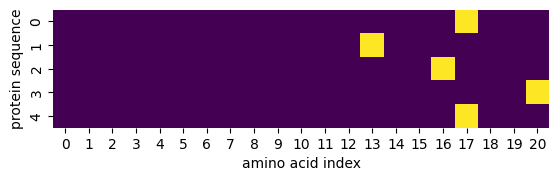

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = sns.heatmap(
    one_hot_encoded_sequence, square=True, cbar=False, cmap='viridis')
fig.set(xlabel='amino acid index', ylabel='protein sequence')
plt.show()

Avoir cette représentation numérique de base d'une séquence protéique nous permet d'interagir mathématiquement avec les protéines. Bien qu'il s'agisse d'un bon point de départ, cette représentation reste trop basique pour être véritablement utile. Examinons maintenant les **embeddings denses et appris des acides aminés**.

## 2.2 Embeddings appris des acides aminés

Tout au long de ce travail pratique, nous utiliserons un modèle de langage protéique pré-entraîné très populaire, appelé **ESM** de Meta. Nous discuterons plus en détail de son fonctionnement dans un instant, mais d'abord, explorons sa représentation des acides aminés.

Le modèle est hébergé sur la plateforme Hugging Face 🤗. Si vous ne connaissez pas encore Hugging Face, il s'agit d'une ressource fantastique regroupant des milliers de modèles pré-entraînés que vous pouvez charger rapidement et commencer à utiliser. Pour accéder au modèle de langage protéique ESM2, nous allons d'abord utiliser la bibliothèque transformers (ESM2 est un modèle basé sur un transformer). Importons le module nécessaire et chargeons le tokenizer et le modèle ESM2 :

In [11]:
from IPython.display import clear_output
from transformers import AutoTokenizer, EsmModel, EsmConfig

model_checkpoint = "facebook/esm2_t30_150M_UR50D"  # From: https://github.com/facebookresearch/esm#available-models-and-datasets-
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = EsmModel.from_pretrained(model_checkpoint)
clear_output()

Nous pouvons examiner la correspondance entre les tokens et les indices utilisée par le tokenizer ESM2 :

In [12]:
vocab_to_index = tokenizer.get_vocab()
vocab_to_index

{'<cls>': 0,
 '<pad>': 1,
 '<eos>': 2,
 '<unk>': 3,
 'L': 4,
 'A': 5,
 'G': 6,
 'V': 7,
 'S': 8,
 'E': 9,
 'R': 10,
 'T': 11,
 'I': 12,
 'D': 13,
 'P': 14,
 'K': 15,
 'Q': 16,
 'N': 17,
 'F': 18,
 'Y': 19,
 'M': 20,
 'H': 21,
 'W': 22,
 'C': 23,
 'X': 24,
 'B': 25,
 'U': 26,
 'Z': 27,
 'O': 28,
 '.': 29,
 '-': 30,
 '<null_1>': 31,
 '<mask>': 32}

Vous pouvez voir que c'est assez similaire à la correspondance entre acides aminés et entiers que nous avons faite manuellement, mais avec des tokens supplémentaires utiles, comme un token pour un acide aminé inconnu (`unk`) et un token désignant la fin de la séquence (`eos` pour 'end of sentence').

Utilisons maintenant le tokenizer pour encoder notre petite séquence protéique :

In [13]:
tokenized_tiny_protein = tokenizer('MALWM')['input_ids']
tokenized_tiny_protein

[0, 20, 5, 4, 22, 20, 2]

Nous pourrions choisir de supprimer les tokens initiaux `cls` et finaux `eos` si nous le souhaitions :

In [14]:
tokenized_tiny_protein[1:-1]

[20, 5, 4, 22, 20]

Extrayons les embeddings pour chaque acide aminé :

In [15]:
token_embeddings = model.get_input_embeddings().weight.detach().numpy()
token_embeddings.shape

(33, 640)

Vous pouvez voir que pour chacun des 33 tokens d'entrée possibles, nous avons un vecteur d'embedding de 640 dimensions.

Bien qu'il soit un peu (!) difficile de visualiser cela en 640 dimensions, nous pouvons utiliser une technique de réduction de dimensions comme tSNE pour ramener cette information à 2 dimensions et tracer la position de chaque token dans ce nouvel espace bidimensionnel :

In [16]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, learning_rate='auto', init='random',
            random_state=123, perplexity=3)
embeddings_tsne = tsne.fit_transform(token_embeddings)
embeddings_tsne_df = pd.DataFrame(
    embeddings_tsne, columns=['first_dim', 'second_dim'])
embeddings_tsne_df.shape

(33, 2)

Let's plot a scatter plot:

<Axes: xlabel='first_dim', ylabel='second_dim'>

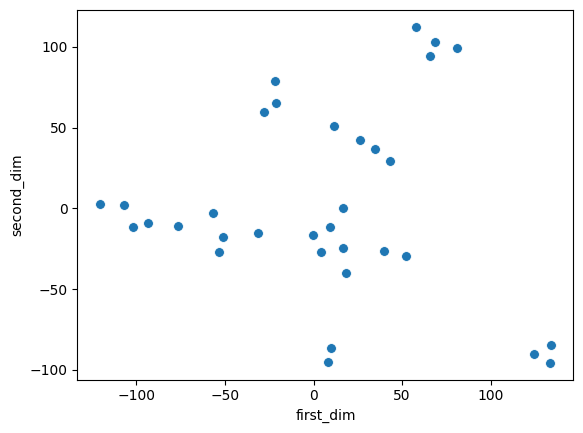

In [17]:
sns.scatterplot(data=embeddings_tsne_df,
                x='first_dim',
                y='second_dim',
                s=50)

Pour voir si des types de tokens et d'acides aminés similaires se regroupent, nous pouvons étiqueter chaque token avec son libellé, puis recréer le graphique en colorant les points en fonction de leur étiquette :

In [18]:
embeddings_tsne_df['token'] = list(vocab_to_index.keys())

token_labels = {
    '<cls>': 'special_token',
    '<pad>': 'special_token',
    '<eos>': 'special_token',
    '<unk>': 'special_token',
    'L': 'hydrophobic',
    'A': 'hydrophobic',
    'G': 'special_amino_acid',
    'V': 'hydrophobic',
    'S': 'polar_uncharged',
    'E': 'negatively_charged',
    'R': 'positively_charged',
    'T': 'polar_uncharged',
    'I': 'hydrophobic',
    'D': 'negatively_charged',
    'P': 'special_amino_acid',
    'K': 'positively_charged',
    'Q': 'polar_uncharged',
    'N': 'polar_uncharged',
    'F': 'hydrophobic',
    'Y': 'hydrophobic',
    'M': 'hydrophobic',
    'H': 'positively_charged',
    'W': 'hydrophobic',
    'C': 'special_amino_acid',
    'X': 'special_amino_acid',
    'B': 'special_amino_acid',
    'U': 'special_amino_acid',
    'Z': 'special_amino_acid',
    'O': 'special_amino_acid',
    '.': 'special_token',
    '-': 'special_token',
    '<null_1>': 'special_token',
    '<mask>': 'special_token'
    }

embeddings_tsne_df['label'] = embeddings_tsne_df['token'].map(token_labels)

embeddings_tsne_df.head(10)

,first_dim,second_dim,token,label
0,39.835510,-26.277987,<cls>,special_token
1,133.873734,-84.617386,<pad>,special_token
2,52.386459,-29.340681,<eos>,special_token
3,133.587402,-95.550804,<unk>,special_token
4,-107.093307,1.806819,L,hydrophobic
5,-76.478951,-10.660676,A,hydrophobic
6,-56.513298,-2.633828,G,special_amino_acid
7,-93.233955,-8.908669,V,hydrophobic
8,-50.963905,-17.939236,S,polar_uncharged
9,34.510292,36.843521,E,negatively_charged


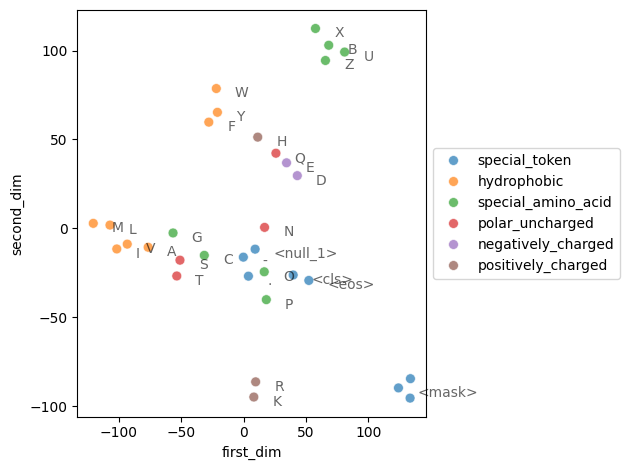

In [19]:
ax = sns.scatterplot(data=embeddings_tsne_df,
                x='first_dim',
                y='second_dim',
                hue='label',
                s=50, alpha=0.7)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

# Add the token name next to its position in the embedding space.
for i, token in enumerate(embeddings_tsne_df['token']):
  plt.annotate(text=token,
               xy=(embeddings_tsne_df['first_dim'][i] + 15,
                   embeddings_tsne_df['second_dim'][i] - 5),
               alpha=0.6)

**Travail de Groupe :**

Super, nous pouvons voir que des types similaires de tokens d'entrée ont tendance à se regrouper dans l'espace !

- Pouvez-vous identifier des sous-catégories intéressantes qui se regroupent ensemble ? Par exemple, examinez les deux groupes de résidus hydrophobes — y a-t-il quelque chose qui différencie ces deux groupes ?

# 3. Protein Language Models Overview

## 3.1 Training Task

Le modèle ESM que nous utilisons est appelé un **M**asked **L**anguage **M**odel (MLM), ou modèle de langage masqué. Les MLM sont entraînés en masquant aléatoirement quelques acides aminés dans la séquence protéique, puis en demandant au modèle de prédire les acides aminés masqués. En général, environ 15 % des acides aminés dans une séquence donnée sont masqués, et ils sont sélectionnés de manière aléatoire chaque fois que le modèle voit la séquence pendant l'entraînement.

En termes simples, c'est une question à trous, comme dans "The quick brown fox `____` over the lazy dog." (une réponse correcte serait "jumped"). Pour les modèles de langage, nous remplaçons les acides aminés manquants par un token spécial `<mask>` au lieu d'un `_____`.

Voyons le modèle prédire un acide aminé masqué.

Quelques ressources supplémentaires :


*   [Hugging face page on MLMs](https://huggingface.co/docs/transformers/main/tasks/masked_language_modeling)
*   Chapter from [Speech and Language Processing](https://web.stanford.edu/~jurafsky/slp3/11.pdf)



In [20]:
MASK_TOKEN_INDEX = vocab_to_index['<mask>']  # Should be 32.

insulin_sequence = (
    'MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGG'
    'GPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN'
)
# Masking the L in the 29th position (0-based).
masked_insulin_sequence = (
    #MALWMRLLPLLALLALWGPDPAAAFVNQH  L   CGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGG
    'MALWMRLLPLLALLALWGPDPAAAFVNQH<mask>CGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGG'
    'GPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN'
)
masked_inputs = tokenizer(masked_insulin_sequence)
masked_ids = masked_inputs['input_ids']
# Note, the tokenizer adds a <cls> token to the start of the protein sequence
# and a <eos> token at the end so we have to add 1 to the index.
assert masked_ids[30] == vocab_to_index['<mask>']
masked_ids[30]  # Verify that the mask token at position 30 is correctly the mask token.

32

Vous pouvez voir que, bien que le token `<mask>` soit composé de plusieurs caractères, il est traduit en un seul token, l'index 32. Cela indique au modèle que l'acide aminé a été masqué et qu'il doit le prédire.

Ensuite, nous verrons si le modèle peut prédire correctement cet acide aminé masqué. Nous allons charger le modèle en utilisant la classe `EsmForMaskedLM` pour obtenir le modèle complet avec la tête de prédiction linguistique. La sortie de ce modèle correspond aux logits des 33 différentes valeurs dans le vocabulaire.

<!-- TODO: Maybe it's good to have a collapsed section here on logits and softmax. -->


In [21]:
from transformers import EsmForMaskedLM
# Note: Use use the `EsmForMaskedLM` class in order to load the
# head for predicting the missing amino acids.
masked_lm_model = EsmForMaskedLM.from_pretrained(model_checkpoint)

Text(0.5, 1.0, 'Model probablilies for masked amino acid.')

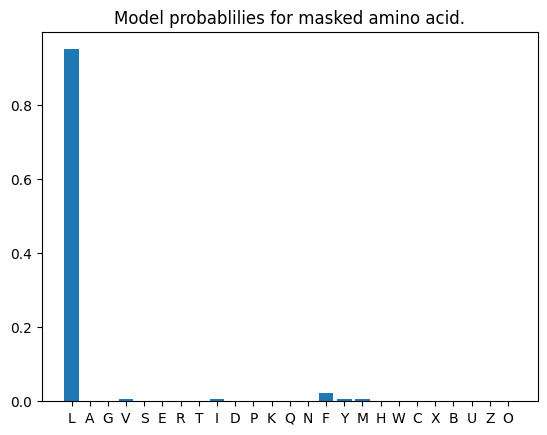

In [22]:
masked_logits = masked_lm_model(**tokenizer(masked_insulin_sequence, return_tensors='pt')).logits
masked_logits = masked_logits[0, 30]  # Tokenizer adds <cls> to start so we add 1.
# Remove the special tokens and apply softmax to convert logits to probabilities.
probs = jax.nn.softmax(masked_logits.detach().numpy())[4:29]
letters = [k for k,_ in vocab_to_index.items()][4:29]
plt.bar(letters, probs)
plt.title('Model probablilies for masked amino acid.')

In this case, the model correctly predicts that the missing amino acid is Leucine (L).

**Travail de Groupe :**

Nous avons fait de grands progrès jusqu'à présent. Nous avons montré comment le modèle prédit les tokens manquants.

Écrivons maintenant une fonction qui :
1. Prend en entrée une `sequence` et un `mask_index`.
2. Remplace l'acide aminé à `mask_index` par le token `<mask>`.
3. Exécute le modèle ESM.
4. Affiche un graphique des probabilités de chaque acide aminé avec le titre "Probabilités des acides aminés prédits pour `<amino acid>` à l'index `<mask_index>`".

**Tâche de suivi :** Essayez maintenant de trouver une position où le modèle se trompe ou est incertain quant aux prédictions.

**Discussion de groupe :** Que signifie cela pour ces acides aminés à ces positions ?

In [23]:
def plot_masked_probabilities(amino_acid_seq: str, mask_index: int):
  """Plots probablilites of masked amino acid.

  Args:
    amino_acid_seq: Amino acid sequence
    mask_index: 0-based index of amino acid position to mask.
  """
  # TODO: Your implementation goes here.
  # HINT: The tokenizer will add a <cls> token to the start
  # of the sequence.
  pass

In [24]:
# Should match above plot.
plot_masked_probabilities(insulin_sequence, 29)

MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGGGPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN
MALWMRLLPLLALLALWGPDPAAAFV<mask>QHLCGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGGGPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN


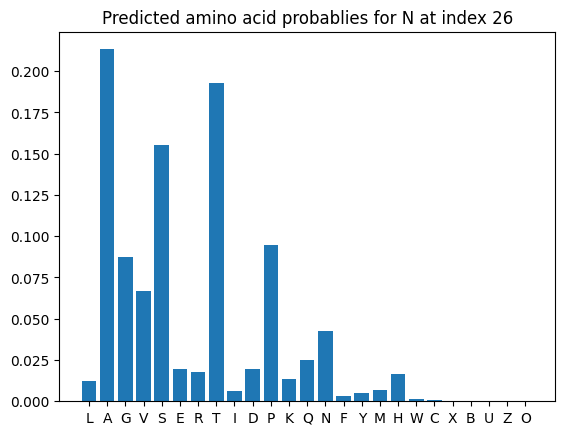

In [25]:
# @title Answer to code task (Try not to peek until you've given it a good try!')

def plot_masked_probabilities(amino_acid_seq: str, mask_index: int):
  """Plots probablilites of masked amino acid.

  Args:
    amino_acid_seq: Amino acid sequence
    mask_index: 0-based index of amino acid position to mask.
  """
  if mask_index < 0 or mask_index > len(amino_acid_seq):
    raise ValueError('Mask index outside of sequence range')
  print(amino_acid_seq)
  masked_seq = amino_acid_seq[0:mask_index] + '<mask>' + amino_acid_seq[(mask_index + 1):]
  print(masked_seq)
  masked_inputs = tokenizer(masked_seq, return_tensors='pt')
  # Remember, the tokenizer will add a <cls> token to the start of the
  # sequence and it will add a batch axis.
  assert masked_inputs['input_ids'][0, mask_index + 1] == MASK_TOKEN_INDEX

  masked_logits = masked_lm_model(**masked_inputs).logits
  masked_logits = masked_logits[0, mask_index + 1]  # Tokenizer adds <cls> to start so + 1.
  # Remove the special tokens and apply softmax to convert logits to probabilities.
  probs = jax.nn.softmax(masked_logits.detach().numpy())[4:29]
  letters = [k for k,_ in vocab_to_index.items()][4:29]
  plt.bar(letters, probs)
  plt.title(f'Predicted amino acid probablies for {amino_acid_seq[mask_index]} at index {mask_index}')

plot_masked_probabilities(insulin_sequence, 26)  # 0-based

Dans ce cas, l'acide aminé manquant est probablement ambigu, tout comme dans la phrase "The `____` fox jumped over the lazy dog.", qui admet de nombreuses réponses possibles, comme big, brown, fast, quick, etc. Ce sont toutes des mots valides pour combler le vide. Cela rend donc difficile pour le modèle de choisir un mot unique et correct.

## [Optional] 3.2 MLMs versus Next Token Prediction (GPT)

Notez qu'il existe une alternative aux MLMs qui consiste à entraîner le modèle à prédire le mot (token) suivant dans une phrase. C'est ainsi que les modèles de type GPT sont entraînés. Cela permet au modèle de prédire chaque mot suivant possible dans une phrase.

Par exemple, le modèle pourrait être confronté à la tâche suivante :

* "`_____`".
* "The `_____`".
* "The child `_____`".
* "The child hit `_____`".
* "The child hit the `_____`".
* "The child hit the ball  `_____`".
* "The child hit the ball with `_____`".
* "The child hit the ball with the `_____`".

Il s'agit également de questions à trous, mais le trou se trouve toujours à la fin de la phrase.

Ces modèles sont en dehors du cadre de ce travail pratique.

# 4. Utilisation des sorties du modèle
La sortie du modèle ESM est constituée d'embeddings mis à jour, avec les mêmes dimensions et la même longueur de séquence que l'entrée, intégrant des informations sur la protéine spécifique et chaque acide aminé.

In [26]:
output = model(**tokenizer(insulin_sequence, return_tensors='pt'))
print(f'Protein sequence length: {len(insulin_sequence)}')
print(f'Model output shape: {output.last_hidden_state.shape}')

Protein sequence length: 110
Model output shape: torch.Size([1, 112, 640])


Les dimensions de chaque composante et leur signification sont les suivantes :
* `1` - Taille de batch
* `112` - `<cls>` + 110 acides aminés + `<eos>`
* `640` - Taille des embeddings du modèle, qui correspond à la taille de nos embeddings d'entrée

Remarquez que la longueur de la sortie variera en fonction de la longueur de la séquence protéique. Souvent, nous voulons faire des prédictions sur des protéines entières. Nous pouvons résumer des protéines de différentes longueurs en moyennant les embeddings le long de la séquence.

Par exemple, nous pouvons visualiser les embeddings moyens de protéines qui se trouvent soit dans le fluide cellulaire (cytosolique), soit fixées dans la membrane de la protéine.

In [27]:
cytosolic_sequences = [
 'MSLRKQTPSDFLKQIIGRPVVVKLNSGVDYRGVLACLDGYMNIALEQTEEYVNGQLKNKYGDAFIRGNNVLYISTQKRRM',
 'MAARALCMLGLVLALLSSSSAEEYVGLSANQCAVPAKDRVDCGYPHVTPKECNNRGCCFDSRIPGVPWCFKPLQEAECTF',
 'MNREGAPGKSPEEMYIQQKVRVLLMLRKMGSNLTASEEEFLRTYAGVVNSQLSQLPPHSIDQGAEDVVMAFSRSETEDRRQ',
 'MPLSDWCCGICEEAPLGRAYTQTWMETGCGPHGVTALGQQELKDCLRARSGGTASSVDWIMEAARGSLNVHNCLIKFGRRD',
 'MATFPPATSAPQQPPGPEDEDSSLDESDLYSLAHSYLGGGGRKGRTKREAAANTNRPSPGGHERKLVTKLQNSERKKRGARR',
 'MASSSGAGAAAAAAAANLNAVRETMDVLLEISRILNTGLDMETLSICVRLCEQGINPEALSSVIKELRKATEALKAAENMTS',
 'MAVFHDEVEIEDFQYDEDSETYFYPCPCGDNFSITKEDLENGEDVATCPSCSLIIKVIYDKDQFVCGETVPAPSANKELVKC',
 'MQNDAGEFVDLYVPRKCSASNRIIGAKDHASIQMNVAEVDKVTGRFNGQFKTYAICGAIRRMGESDDSILRLAKADGIVSKNF',
 'MSGPNGDLGMPVEAGAEGEEDGFGEAEYAAINSMLDQINSCLDHLEEKNDHLHARLQELLESNRQTRLEFQQQLGEAPSDASP',
 'MALSVLRLALLLLAVTFAASLIPQFGLFSKYRTPNCSQYRLPGCPRHFNPVCGSDMSTYANECTLCMKIREGGHNIKIIRNGPC']

membrane_sequences = [
 'MGRAMVARLGLGLLLLALLLPTQIYSSETTTGTSSNSSQSTSNSGLAPNPTNATTKAAGGALQSTASLFVVSLSLLHLYS',
 'MATPTQTPTKAPEEPDPFYYDYNTVQTVGMTLATILFLLGILIVISKKVKCRKADSRSESPTCKSCKSELPSSAPGGGGV',
 'MKYPLMPLVNDLTFSFLVFWFCLPVGLLLLLIIWLRFLLSQDSEENDSSVCLDWEPWSKGPAEFCWKGTLHGQEKERPCW',
 'MAYHGLTVPLIVMSVFWGFVGFLVPWFIPKGPNRGVIITMLVTCSVCCYLFWLIAILAQLNPLFGPQLKNETIWYLKYHWP',
 'MDGGQPIPSSLVPLGNESADSSMSLEQKMTFVFVILLFIFLGILIVRCFRILLDPYRSMPTSTWADGLEGLEKGQFDHALA',
 'MSSTYCGNSSAKMSVNEVSAFSLTLEQKTGFAFVGILCIFLGLLIIRCFKILLDPYSSMPSSTWEDEVEEFDKGTFEYALA',
 'MSATWTLSPEPLPPSTGPPVGAGLDAEQRTVFAFVLCLLVVLVLLMVRCVRILLDPYSRMPASSWTDHKEALERGQFDYALV',
 'MAVSTEELEATVQEVLGRLKSHQFFQSTWDTVAFIVFLTFMGTVLLLLLLVVAHCCCCSSPGPRRESPRKERPKGVDNLALEP',
 'MEALGSGHYVGGSIRSMAAAALSGLAVRLSRPQGTRGSYGAFCKTLTRTLLTFFDLAWRLRKNFFYFYILASVILNVHLQVYI',
 'MDLSFMAAQLPMMGGAFMDSPNEDFSTEYSLFNSSANVHAAANGQGQPEDPPRSSNDAVLLWIAIIATLGNIVVVGVVYAFTF']

Nous allons extraire les embeddings pour chaque séquence, puis calculer la moyenne sur la longueur de la séquence.

**Travail de Groupe :** Écrivez une fonction pour calculer l'embedding moyen sur la séquence.

In [28]:
def sequence_embeddings(sequences, device='cpu'):
  model_inputs = tokenizer(sequences,padding=True, return_tensors='pt')
  model_inputs = {k:v.to(device) for k,v in model_inputs.items()}
  outputs = model(**model_inputs)
  # TODO: Implement averaging. Should convert shape
  # shape (<Batch>, <Sequence Length>, <Embedding>) -> (<Batch>, <Embedding>)


In [29]:
# @title Answer to code task (Try not to peek until you've given it a good try!')

def sequence_embeddings(sequences, device='cpu'):
  model_inputs = tokenizer(sequences,padding=True, return_tensors='pt')
  model_inputs = {k:v.to(device) for k,v in model_inputs.items()}
  outputs = model(**model_inputs)
  embeddings = outputs.last_hidden_state.detach().cpu().numpy()
  seq_len = model_inputs['attention_mask'].cpu().sum(axis=-1, keepdims=True)
  return np.sum(embeddings, axis=1) / seq_len  # Average along sequence dimension.

###### Now we'll compute this for the sequences.

In [30]:
cytosolic_embeddings = sequence_embeddings(cytosolic_sequences)
membrane_embeddings = sequence_embeddings(membrane_sequences)
combined_embeddings = np.concatenate([cytosolic_embeddings, membrane_embeddings], axis=0)

In [31]:
combined_embeddings.shape

(20, 640)

Remarquez que, même si les longueurs des protéines sont différentes, les embeddings moyennés ont tous la même longueur.

Cela facilite ensuite l'intégration dans des classifieurs en aval qui nécessitent une longueur de caractéristiques fixe, comme un Random Forest ou un simple Perceptron Multicouche.

In [32]:
embeddings_tsne = TSNE(n_components=2, learning_rate='auto',
                       init='random', random_state=123, perplexity=3).fit_transform(combined_embeddings)
embeddings_tsne_df = pd.DataFrame(
    embeddings_tsne, columns=['first_dim', 'second_dim'])
embeddings_tsne_df['type'] = ['Cytosolic'] * len(cytosolic_sequences) + ['Membrane'] * len(membrane_sequences)

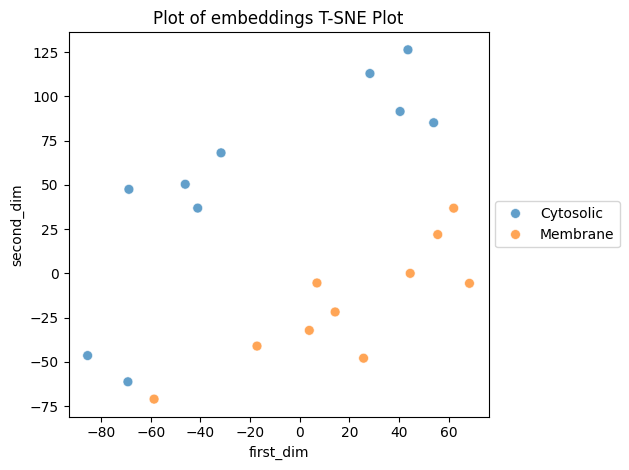

In [33]:
ax = sns.scatterplot(data=embeddings_tsne_df,
                x='first_dim',
                y='second_dim',
                hue='type',
                s=50, alpha=0.7)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Plot of embeddings T-SNE Plot')
plt.tight_layout()

Comme vous pouvez le voir, il y a un bon regroupement des différents types de protéines. Cela signifie que les embeddings contiennent des informations sur l'emplacement de la protéine dans la cellule.

# 5. Entraîner un modèle

Dans cette section, nous allons utiliser les embeddings pour entraîner un modèle simple en utilisant les embeddings d'acides aminés précédemment utilisés.

<!-- !['Paths to Follow'](https://assets.stickpng.com/images/580b57fbd9996e24bc43bce5.png) -->
<img src="https://assets.stickpng.com/images/580b57fbd9996e24bc43bce5.png" width="60%">

En guise d'exemple, nous allons examiner la liaison d'anticorps antivenimeux de serpent. Les morsures de serpent causent plus de 100 000 décès et plus de 300 000 défigurations permanentes chaque année, causées par les protéines toxiques dans le venin de serpent.

_Note : Si la biologie ne vous intéresse pas, passez directement au **TL;DR** ci-dessous !_

Actuellement, le seul traitement efficace contre l'envenimation par morsure de serpent consiste en des cocktails non spécifiques d'anticorps polyclonaux. Ces anticorps antivenimeux fonctionnent de manière peu fiable entre différentes espèces de serpents et, jusqu'à récemment, il existait peu de données sur les plus de 2000 toxines de venin de serpent auxquelles ils se lient, ainsi que sur l'emplacement de la liaison de l'anticorps à la toxine.

Pour résoudre ce problème, une étude récente a utilisé la technologie HDPM (microarrays de peptides à haute densité) avec toutes les séquences de protéines de toxines de serpent africain actuellement disponibles, ainsi que huit antivenins commerciaux en usage clinique en Afrique pour mieux comprendre comment les antivenins se lient aux toxines spécifiques du venin de serpent.

Nous utiliserons le jeu de données de cette étude, qui mesure la réactivité croisée des huit antivenins de serpent et identifie où, dans la séquence de toxine, les anticorps se lient à la toxine (épitopes).

!['Paths to Follow'](https://i.ibb.co/sgtcN4v/ml-for-bio-02-720.png)

**TL;DR : Je ne suis pas biologiste !**
- **Entrée** : Dans cette tâche, nous aurons une séquence de 16 acides aminés \
  Exemple : `NLYQFKNMIQCTVPNR`
- **Cible** : Nous allons prédire une valeur scalaire `Signal` \
  Exemple : -0,53
- Nous ferons cela pour chaque type d'`Antivenin`.

Le jeu de données que nous utiliserons provient de la [African Snake Antivenom Binding Challenge](https://zindi.africa/competitions/umojahack-africa-2022-advanced-challenge) hébergé sur [Zindi](https://zindi.africa/).

## 5.1 Loading the data



Reading in the data with Pandas

In [34]:
data_df = pd.read_csv("https://storage.googleapis.com/umojahack2022/train.csv")
data_df.head(5)

,ID,Toxin_UniprotID,Kmer_Position_start,Kmer_Position_end,Antivenom,Toxin_Kmer,Signal,Genus,Species,ProteinFam,ProteinSubFam,ProteinSubSubFam
0,P07037_Bioclone_1,P07037,1,16,Bioclone,NLYQFKNMIQCTVPNR,-0.53,Aspidelaps,Aspidelaps_scutatus,Phospholipase_A2,Group_I_subfamily,D49_sub_subfamily
1,P07037_Bioclone_2,P07037,2,17,Bioclone,LYQFKNMIQCTVPNRS,-1.00,Aspidelaps,Aspidelaps_scutatus,Phospholipase_A2,Group_I_subfamily,D49_sub_subfamily
2,P07037_Bioclone_3,P07037,3,18,Bioclone,YQFKNMIQCTVPNRSW,-0.21,Aspidelaps,Aspidelaps_scutatus,Phospholipase_A2,Group_I_subfamily,D49_sub_subfamily
3,P07037_Bioclone_4,P07037,4,19,Bioclone,QFKNMIQCTVPNRSWW,-0.30,Aspidelaps,Aspidelaps_scutatus,Phospholipase_A2,Group_I_subfamily,D49_sub_subfamily
4,P07037_Bioclone_5,P07037,5,20,Bioclone,FKNMIQCTVPNRSWWH,-1.00,Aspidelaps,Aspidelaps_scutatus,Phospholipase_A2,Group_I_subfamily,D49_sub_subfamily


Chaque ligne du jeu de données représente un k-mer (une séquence de 16 acides aminés au sein de la toxine) et contient une colonne de signal issue de l'expérience de microarray de peptides à haute densité. Nous allons donc prédire la colonne de signal générée par un `Toxin_K_mer` et un `Antivenom` donnés.

Note : Un k-mer est une sous-séquence d'une protéine complète, composée de `K` acides aminés consécutifs.

## 5.2 Division et prétraitement

Commençons par diviser les données en un ensemble d'entraînement et un ensemble de validation. Pour éviter toute fuite de données entre nos ensembles d'entraînement et de validation, nous effectuerons la division en fonction des toxines uniques.

In [35]:
unique_toxins = data_df['Toxin_UniprotID'].unique()
print(f"There are {unique_toxins.shape[0]} unique toxins")

There are 237 unique toxins


Lets randomly select ~10% of the toxins for validation

**Code task:** Create a training-validation split using the `unique_toxins` calculated above.

_hint: Use sklearn's `train_test_split` ([see usage here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html))_

In [ ]:
from sklearn.model_selection import train_test_split
train_toxins, valid_toxins = ... # YOUR CODE GOES HERE

In [37]:
# @title Answer to code task (Try not to peek until you've given it a good try!')

from sklearn.model_selection import train_test_split
train_toxins, valid_toxins = train_test_split(unique_toxins, test_size=0.1)

In [38]:
print(f"Train has {train_toxins.shape[0]} toxins, validation has {valid_toxins.shape[0]} toxins")

Train has 213 toxins, validation has 24 toxins


We can now find the full training and validation dataframes
Nous pouvons désormais retrouver les dataframes complets de *training* et de *validation*

In [39]:
train_df = data_df[data_df["Toxin_UniprotID"].isin(train_toxins)]
valid_df = data_df[data_df["Toxin_UniprotID"].isin(valid_toxins)]
print(f"train_df has {train_df.shape[0]} rows, valid_df has {valid_df.shape[0]} rows")

train_df has 112622 rows, valid_df has 11495 rows


Nous allons maintenant convertir les données dans un format que [flax](https://flax.readthedocs.io/en/latest/) et [Jax](https://jax.readthedocs.io/en/latest/) peuvent comprendre. Cela implique de :

1. Extraire les embeddings des acides aminés
2. Encoder les chaînes d'antivenin (c'est-à-dire créer un vocabulaire d'antivenins)
3. Extraire la colonne de signal

Let's first get all the mean embeddings per toxin K-mer, to do this, we will use the `sequence_embeddings()` function from Section 4. Recall: the `sequence_embeddings()` function takes in a string of amino acids, and returns the mean-pooled embedding.

To speed things up, we will calculate the embeddings on the GPU if available.

In [40]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model = model.eval()
device

'cuda'

Nous commençons par créer un dictionnaire qui associe chaque k-mer unique de toxine à son embedding moyenné. Ce dictionnaire `kmer_embedding` pourra ensuite être utilisé pour retrouver les embeddings lors de la mise en forme des données d'entrée.

In [41]:
# This cell can take 5~10 minutes on colab with a GPU
from tqdm.notebook import tqdm

k_mers = data_df['Toxin_Kmer'].unique()
print(f"There are {k_mers.shape[0]} unique k-mers")

kmer_embedding = {}

with torch.no_grad():
    for k_mer in tqdm(k_mers, total=len(k_mers)):
        kmer_embedding[k_mer] = sequence_embeddings(k_mer, device=device).numpy()[0]

There are 11954 unique k-mers


  0%|          | 0/11954 [00:00<?, ?it/s]

In [42]:
# try clear some GPU memory
model = model.to('cpu')
torch.cuda.empty_cache()

Nous allons maintenant convertir l'ensemble des données en un dataset TensorFlow pratique et facile à utiliser.

In [43]:
# Uses embeddings
vocab = set("".join(data_df['Toxin_Kmer']))
aa_to_idx = {aa:i for i,aa in enumerate(vocab)}
av_to_idx = {av:i for i,av in enumerate(data_df['Antivenom'].unique())}


def convert_to_tfds(df):
    k_mers, antivenoms, targets = [], [], []
    for _,row in tqdm(df.iterrows(), total=len(df)):
        k_mer = kmer_embedding[row['Toxin_Kmer']]
        k_mers.append(k_mer)

        antivenoms.append(av_to_idx[row['Antivenom']])
        targets.append(row['Signal'])
    ds = tf.data.Dataset.from_tensor_slices({"sequence": np.stack(k_mers), "antivenom": np.array(antivenoms), "target": np.array(targets)})
    return ds

In [44]:
train_ds = convert_to_tfds(train_df)
valid_ds = convert_to_tfds(valid_df)

  0%|          | 0/112622 [00:00<?, ?it/s]

  0%|          | 0/11495 [00:00<?, ?it/s]

In [45]:
BATCH_SIZE=128

train_ds = train_ds.shuffle(1024)
train_ds = train_ds.batch(BATCH_SIZE)
valid_ds = valid_ds.batch(BATCH_SIZE)

In [46]:
batch = next(iter(train_ds))
batch['sequence'].shape, batch['antivenom'].shape, batch['target'].shape

(TensorShape([128, 640]), TensorShape([128]), TensorShape([128]))

## 5.3 Création d'un MLP simple

Nous allons maintenant entraîner un modèle simple avec [flax](https://flax.readthedocs.io/en/latest/) en utilisant les embeddings des acides aminés.

Le modèle aura deux entrées : l'embedding moyen des acides aminés et l'`antivenin` à évaluer. Pour l'`antivenin`, nous pouvons utiliser une couche `nn.Embed` avec une taille de vocabulaire de 8.

Nous concaténons l'embedding moyen des acides aminés avec l'embedding de l'`antivenin` et le passons dans un MLP simple. N'hésitez pas à apporter des ajustements au modèle pour essayer d'améliorer les performances !

In [47]:
class Model(nn.Module):
    dim: int = 128
    av_vocab_size: int = 8

    @nn.compact
    def __call__(self, batch):
        x = nn.Embed(self.av_vocab_size, self.dim)(batch['antivenom'])

        x = jnp.concatenate([batch['sequence'], x], axis=1)

        x = nn.Sequential(
            [
                nn.Dense(self.dim*2),
                jax.nn.gelu,
                nn.Dense(self.dim),
                jax.nn.gelu,
                nn.Dense(1),
            ]
        )(x)

        return x

In [48]:
av_model = Model(dim=256, av_vocab_size=len(av_to_idx))

## 5.4 Training loop

With all the model and data set up, we can now train the model

In [49]:
LR = 0.01

init_rng = jax.random.PRNGKey(42)
dummy_batch = jax.tree_util.tree_map(jnp.array, batch)
variables = av_model.init(
  init_rng,
  dummy_batch # <== inputs
)
params = variables["params"]

optimiser = optax.adam(LR)
opt_state = optimiser.init(params)

**Tâche de code :** Complétez le code d'entraînement suivant
- Ajoutez le calcul de la perte MSE (erreur quadratique moyenne)
- Mettez à jour les paramètres du modèle avec optax

In [50]:
@jax.jit
def train_step(params, opt_state, batch):
    def loss_fn(params):
        preds = av_model.apply(
            {'params': params},
            batch # <== inputs
        )
        loss = ... # YOUR CODE GOES HERE
        return loss

    loss, grads = jax.value_and_grad(loss_fn)(params)
    # YOUR CODE GOES HERE
    # Hint: Refer to optax docs if you need help!

    return params, opt_state, loss

In [51]:
# @title Answer to code task (Try not to peek until you've given it a good try!')

@jax.jit
def train_step(params, opt_state, batch):
    def loss_fn(params):
        preds = av_model.apply(
            {'params': params},
            batch # <== inputs
        )
        loss = jnp.power(batch['target'] - preds.squeeze(), 2).mean()
        return loss

    loss, grads = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = optimiser.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

    return params, opt_state, loss

### It's go time! 🚀

Time to train our model!

In [52]:
%%time
from tqdm import tqdm

EPOCHS = 10
key = jax.random.PRNGKey(42)

for epoch in range(EPOCHS):
    running_loss = None
    pbar = tqdm(enumerate(train_ds), total=len(train_ds))
    for i, batch in pbar:
        batch = jax.tree_util.tree_map(jnp.array, batch)

        params, opt_state, loss = train_step(params, opt_state, batch)

        if running_loss is None:
            running_loss = loss.item()
        else:
            running_loss = 0.99 * running_loss + (1 - 0.99) * loss

        pbar.set_postfix({'loss': running_loss})


    valid_losses = []
    for i, batch in tqdm(enumerate(valid_ds), total=len(valid_ds)):
        batch = jax.tree_util.tree_map(jnp.array, batch)

        preds = av_model.apply(
            {'params': params},
            batch # <== inputs
        )
        loss = jnp.power(batch['target'] - preds, 2).mean()

        valid_losses.append(loss)

    valid_loss = np.mean(valid_losses)

    print(f"[Epoch {epoch}]: Valid loss={valid_loss:.3f}, Train loss={running_loss:.3f}\n")

100%|██████████| 90/90 [00:02<00:00, 33.67it/s]


[Epoch 0]: Valid loss=1.505, Train loss=0.657



100%|██████████| 90/90 [00:02<00:00, 32.26it/s]


[Epoch 1]: Valid loss=1.540, Train loss=0.601



100%|██████████| 90/90 [00:02<00:00, 44.70it/s]


[Epoch 2]: Valid loss=1.509, Train loss=0.567



100%|██████████| 90/90 [00:01<00:00, 50.86it/s]


[Epoch 3]: Valid loss=1.626, Train loss=0.545



100%|██████████| 90/90 [00:02<00:00, 33.86it/s]


[Epoch 4]: Valid loss=1.471, Train loss=0.522



100%|██████████| 90/90 [00:01<00:00, 46.14it/s]


[Epoch 5]: Valid loss=1.502, Train loss=0.516



100%|██████████| 90/90 [00:01<00:00, 45.51it/s]


[Epoch 6]: Valid loss=1.565, Train loss=0.493



100%|██████████| 90/90 [00:02<00:00, 31.81it/s]


[Epoch 7]: Valid loss=1.467, Train loss=0.492



100%|██████████| 90/90 [00:01<00:00, 45.77it/s]


[Epoch 8]: Valid loss=1.689, Train loss=0.473



100%|██████████| 90/90 [00:02<00:00, 42.81it/s]


[Epoch 9]: Valid loss=1.595, Train loss=0.459

CPU times: user 1min 11s, sys: 8.63 s, total: 1min 19s
Wall time: 1min 28s


And we're done! We've implemented a simple MLP model that utilises the rich information provided by the pre-trained protein language model.

## 5.4 Final challenge

**Coding Task:**

While the model is learning, it is in no way optimal. Could you create a model that improves the MSE loss?

- One idea is to use some sort of RNN (such as an LSTM) or Conv net on the amino-acid embeddings, rather than mean-pooling them! You lose a lot of information by mean-pooling, but the trade-off is it becomes expensive to compute large sequence lengths.
  - For RNNs, check the documentation [here](https://flax.readthedocs.io/en/latest/api_reference/flax.linen/_autosummary/flax.linen.RNN.html)
  - For Convolutional networks, check the documentation [here](https://flax.readthedocs.io/en/latest/api_reference/flax.linen/_autosummary/flax.linen.Conv.html)
  - **Note:** You may have to modify the code that extracts embeddings in order to retain the sequence dimension!
- Another idea is to include the other metadata, such as Species and Protein Family.
  - For these it's recommended to use `nn.Embed`!

# 6. Further Resources

We hope that this practical has got you excited about applying machine learning to biology!

If you'd like to venture a little deeper down this rabbit hole, here are some of the resources we found useful in preparing this practical:
1. [I should have loved biology ](https://jsomers.net/i-should-have-loved-biology/) (Essay by James Somers)
2. [The Most Complex Language in the World](https://www.youtube.com/watch?v=TYPFenJQciw) (Youtube video by Kurzgesagt)
3. [Language models of protein sequences at the scale
of evolution enable accurate structure prediction](https://www.biorxiv.org/content/10.1101/2022.07.20.500902v1.full.pdf) (ESM paper)
4. [Inner Life of a Cell | Protein Packing Animation](https://www.youtube.com/watch?v=uHeTQLNFTgU) (Protein packing animation)

Today we have focussed on proteins, but the field of biology is enormous and there is plently of other areas ripe for research! From drug discovery, modelling genes to studying the brain! Best of luck for your journey ahead 🚀

In [ ]:
# @title Generate Feedback Form. (Run Cell)
from IPython.display import HTML

HTML(
    """
<iframe
	src="https://forms.gle/Cg9aoa7czoZCYqxF7",
  width="80%"
	height="1200px" >
	Loading...
</iframe>
"""
)

<img src="https://baobab.deeplearningindaba.com/static/media/indaba-logo-dark.d5a6196d.png" width="50%" />